# Tutorial - Exploration-Exploitation in Reinforcement Learning

In this tutorial, we will implement the **UCBVI** algorithm*, for exploration in MDPs with finite states and actions.

*From the paper [Minimax Regret Bounds for Reinforcement Learning](https://arxiv.org/abs/1703.05449) by Azar et al. (2017).
See also slide 25 [here](https://emiliekaufmann.github.io/Cours7_RL21.pdf) (pdf page 33).


## - Elève 1 : Hadrien Salem
## - Elève 2 : Emilie Salem

## A quick review of UCBVI

The UCBVI algorithm works as follows:

* In each episode $t$, the agent has observed $n_t$ transitions $(s_i, a_i, r_i, s_{i+1})_{i=1}^{n_t}$ of states, actions, rewards and next states.
* We estimate a model of the MDP as:
$$
\mathbf{rewards:}\quad\widehat{R}_t(s, a) = \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i)\} r_i
\\
\mathbf{transitions:}\quad \widehat{P}_t(s'|s, a) =  \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i, s'=s_{i+1}\} 
$$
where
$$
N_t(s, a) = \max\left(1, \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i)\} \right)
$$
* We define exploration bonuses as
$$
B_t(s, a) \propto \sqrt{\frac{1}{N_t(s, a)}} \cdot
$$

* Then, in episode $t$, we compute $\{Q_h^t(s, a)\}_{h=1}^H$ as the ($H$-horizon) optimal value functions in the MDP whose transitions are $\widehat{P}_t$ and whose rewards are $(\widehat{R}_t + B_t)$. At step $h$ of episode $t$, the agent chooses the action $a_h^t \in \arg\max_a Q_h^t(s, a)$.

## Colab setup

In [1]:
# After installing, you may need to restart the kernel
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. You may need to restart the runtime after the installation.")

  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git#egg=rlberry[default] > /dev/null 2>&1

  # install gym
  !pip install gym[all] > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get update > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Installing packages, please wait a few moments. You may need to restart the runtime after the installation.


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [3]:
# Useful imports
import numpy as np
import numba
import matplotlib.pyplot as plt
from copy import deepcopy
from gym.wrappers import Monitor

## Environment

In [4]:
def render(env, policy=None, horizon=180):
  env = deepcopy(env)
  env = Monitor(env, './gym_videos', force=True, video_callable=lambda episode: True)
  for episode in range(1):
    done = False
    state = env.reset()
    env.render()
    for hh in range(horizon):
        if policy is not None:
          action = policy[hh, state]
        else:
          action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        env.render()
    env.close()
    show_video(directory='gym_videos')

In [5]:
import gym
from rlberry.wrappers import DiscretizeStateWrapper
from rlberry.agents.mbqvi import MBQVIAgent


class MountainCatRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        if done:
            reward = 1.0
        else:
            reward = 0.0
        done = False 
        return next_state, reward, done, info

def get_mountain_car_env():
  env_with_continuous_states = MountainCatRewardWrapper(gym.make('MountainCar-v0'))
  env = DiscretizeStateWrapper(env_with_continuous_states, n_bins=10)
  return env

env = get_mountain_car_env()
print(env.observation_space)
print(env.action_space)
render(env)

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 


INFO: Making new env: MountainCar-v0
100-element Discrete space
Discrete(3)
INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/gym_videos/openaigym.video.0.7456.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym_videos')


# Implementation of backward induction (value iteration)

Complete the code below in order to compute the optimal policy in a finite-horizon MDP.


You will use it in the implementation of UCBVI to compute the optimal policy for the MDP whose transitios are $\widehat{P}_t$ and whose rewards are $(\widehat{R}_t + B_t)$.


In [6]:
@numba.jit(nopython=True)  # use this to make the code much faster!
def backward_induction(P, R, H, gamma=1.0):
    """
    Parameters:
        P: transition function (S,A,S)-dim matrix
        R: reward function (S,A)-dim matrix
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems!

    Returns:
        The optimal V-function: array of shape (horizon, S)
        The optimal policy: array of shape (horizon, S)

        Where the optimality is with respect to the model (R, P)

        Attention: If (R, P) is not the true MDP, the value function computed
        here is **not** optimal in the true MDP (of course!).
        """
    S, A = P.shape[0], P.shape[1]
    policy = np.zeros((H, S))
    V = np.zeros((H + 1, S))
    for h in range(H-1, -1, -1):
        for s in range(S):
            """ 
            Here, compute V(h, s) using the Bellman optimality equation:

            V[h, s] = max_a { R[s, a] + gamma * sum_{s'} P[s, a, s'] * V[h+1, s'] }
            """
            # value iteration
            values = []
            for a in range(A):
              sum = 0
              for ns in range(S): # next state
                sum += P[s,a,ns] * V[h+1, ns]
              values.append(R[s,a] + gamma*sum)
            V[h,s] = max(values) # computing value
            policy[h,s] = np.array(values).argmax() # computing policy
              
            # clip the value of V[h, s]
            if V[h, s] > H - h:
              V[h, s] = H - h

    return V, policy

In [7]:
# Testing the implementation in a GridWorld
from rlberry.envs import GridWorld

test_env = GridWorld(nrows=8, ncols=8)
_, test_policy = backward_induction(test_env.P, test_env.R, 100, gamma=1.0)
test_policy = test_policy.astype(np.int)

state = test_env.reset()
test_env.enable_rendering()
for tt in range(100):   
  action = test_policy[tt, state]
  next_state, reward, is_terminal, info = test_env.step(action)
  if is_terminal:
    break
  state = next_state

# save video (run last cell to visualize it!)
test_env.save_video('./videos/value_iteration_policy.mp4', framerate=10)
# clear rendering data
test_env.clear_render_buffer()
test_env.disable_rendering()
# see video
show_video(filename='./videos/value_iteration_policy.mp4')

# Implementation of UCBVI

Complete the missing parts in the function below, which implements UCBVI.

In [13]:
def UCBVI(env, H, nb_episodes):
    S = env.observation_space.n # states
    A = env.action_space.n # actions
    policy = np.zeros((H, S), dtype=np.int) # policy
    Phat = np.ones((S,A,S)) / S # estimate of transition probabilities
    Rhat = np.zeros((S,A)) # estimate of rewards
    N_sas = np.zeros((S,A,S), dtype=np.int) # number of times action was taken in state s and s' was reached
    N_sa = np.zeros((S,A), dtype=np.int) # number of times action a was taken in state s
    episode_rewards = np.zeros((nb_episodes,)) # actual rewards
  
    for k in range(nb_episodes):
        sum_rewards = 0

        # computing bonus
        nn = np.maximum(N_sa, 1)
        bonus = 1/np.sqrt(nn) 
        # bonus = 1/np.sqrt(nn) + H/np.sqrt(nn) # other possibility

        # run optimistic value iteration
        optimistic_value, optimistic_policy = backward_induction(Phat, Rhat + bonus, H)
        optimistic_policy = optimistic_policy.astype(np.int)

        # execute policy
        initial_state = state = env.reset()
        for h in range(H):
            action = optimistic_policy[h, state]
            next_state, reward, done, _ = env.step(action)

            sum_rewards += reward
            
            N_sa[state, action] += 1
            N_sas[state, action, next_state] +=1

            # computing reward estimate
            Rhat[state, action] = (1/N_sa[state, action]) * (Rhat[state, action]*(N_sa[state, action]-1) + reward)

            # computing transition probabilities estimate
            Phat[state, action, :] = (1/N_sa[state, action])* N_sas[state, action, :]

            # go to next state
            state = next_state
        
        # update sum of rewards
        episode_rewards[k] = sum_rewards
        
        if k % 50 == 0 or k==1:
            print("rewards[{}]: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", (N_sa.sum(axis=1) > 0).sum() )
            # print(V[0, :])

    return episode_rewards, N_sa, Rhat, Phat, optimistic_value, optimistic_policy

In [16]:
NUM_REPETITIONS = 1
HORIZON = 180
NUM_EPISODES = 1000

env = get_mountain_car_env()

rewards = np.zeros((NUM_REPETITIONS, NUM_EPISODES))
for sim in range(NUM_REPETITIONS):
    print(f"Running simulation: {sim}")
    rewards[sim], N_sa, Rhat, Phat, value, policy = UCBVI(env, H=HORIZON, nb_episodes=NUM_EPISODES)

INFO: Making new env: MountainCar-v0
Running simulation: 0
rewards[0]: 0.0, Number of visited states:  12
rewards[1]: 0.0, Number of visited states:  16
rewards[50]: 20.0, Number of visited states:  76
rewards[100]: 12.0, Number of visited states:  78
rewards[150]: 68.0, Number of visited states:  79
rewards[200]: 34.0, Number of visited states:  79
rewards[250]: 37.0, Number of visited states:  79
rewards[300]: 71.0, Number of visited states:  79
rewards[350]: 71.0, Number of visited states:  79
rewards[400]: 92.0, Number of visited states:  80
rewards[450]: 26.0, Number of visited states:  81
rewards[500]: 94.0, Number of visited states:  83
rewards[550]: 0.0, Number of visited states:  83
rewards[600]: 13.0, Number of visited states:  83
rewards[650]: 5.0, Number of visited states:  83
rewards[700]: 15.0, Number of visited states:  83
rewards[750]: 34.0, Number of visited states:  83
rewards[800]: 21.0, Number of visited states:  83
rewards[850]: 14.0, Number of visited states:  83


In [17]:
render(env, policy)

INFO: Clearing 4 monitor files from previous run (because force=True was provided)
INFO: Starting new video recorder writing to /content/gym_videos/openaigym.video.3.7456.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym_videos')


# Visualizing the final value function at h=0

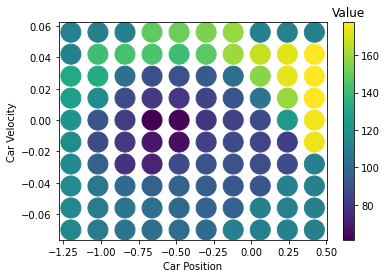

In [18]:
plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
plt.xlabel('Car Position')
plt.ylabel('Car Velocity')
clb=plt.colorbar()
clb.ax.set_title('Value')
plt.show()